## Trabajo práctico N° 1

Una plataforma de ventas online nos contrata para que realicemos un modelo que nos permita detectar un posible fraude dada cierta operación para ello contamos con un dataset que contiene las siguientes columnas:
* Step: representa una unidad de tiempo donde 1 step equivale a 1 hora
* type: tipo de transacción en línea
* amount: el importe de la transacción
* nameOrig: cliente que inicia la transacción
* oldbalanceOrg: saldo antes de la transacción
* newbalanceOrig: saldo después de la transacción
* nameDest: destinatario de la transacción
* oldbalanceDest: saldo inicial del destinatario antes de la transacción
* newbalanceDest: el nuevo saldo del destinatario después de la transacción
* isFraud: transacción fraudulenta

Utilizando los modelos de clasificación vistos hasta el momento  generar un notebook que permita de ser posible resolver el problema que nos está planteando el cliente.


https://www.kaggle.com/datasets/rupakroy/online-payments-fraud-detection-dataset

### Descarga del dataset

Desde el link de arriba se descarga el .zip que contiene al dataset y se lo descomprime para comenzar a trabajar.

In [1]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"carlosstrumia","key":"695c611073be593638f529e915b857dc"}'}

In [2]:
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d rupakroy/online-payments-fraud-detection-dataset

 97% 172M/178M [00:01<00:00, 85.5MB/s]
100% 178M/178M [00:02<00:00, 92.5MB/s]


Se extrae el archivo .zip que contiene el dataset.

In [4]:
from zipfile import ZipFile

file_name="/content/online-payments-fraud-detection-dataset.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print("Hecho")

Hecho


### Librerías de Python

Se importan las librerías necesarias para trabajar con el dataset.

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Partición de train-test set
from sklearn.model_selection import train_test_split

# Imputación y codificación
#from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder

# Entrenamiento de modelos de prueba
from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC

# Evaluación de modelos de prueba
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, classification_report

# Desbalance de clases
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

### Análisis exploratorio de datos

Se carga el dataset a la variable dataframe **df** y se previsualiza el encabezado.

In [6]:
df = pd.read_csv('PS_20174392719_1491204439457_log.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Veamos un poco que tipo de variables hay en el dataset.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


Se chequea si existen datos faltantes (Nan) en el dataset para ver si es necesaria una imputación. El dataset no tiene datos faltantes en ninguna de sus features ni en la variable objetivo ('isFraud'), por lo tanto, no es necesario ningún tipo de imputación.

In [8]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Se realiza un describe para tener un pantallazo general de los principales datos estadísticos de las variables numéricas.

In [9]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


Funcion de utilería para mostrar distribuciones.

In [10]:
def display_dataset_distributions(dataset):
    fig = dataset.hist(xlabelsize=12, ylabelsize=12,figsize=(22,10))
    [x.title.set_size(14) for x in fig.ravel()]
    plt.tight_layout()
    plt.show()

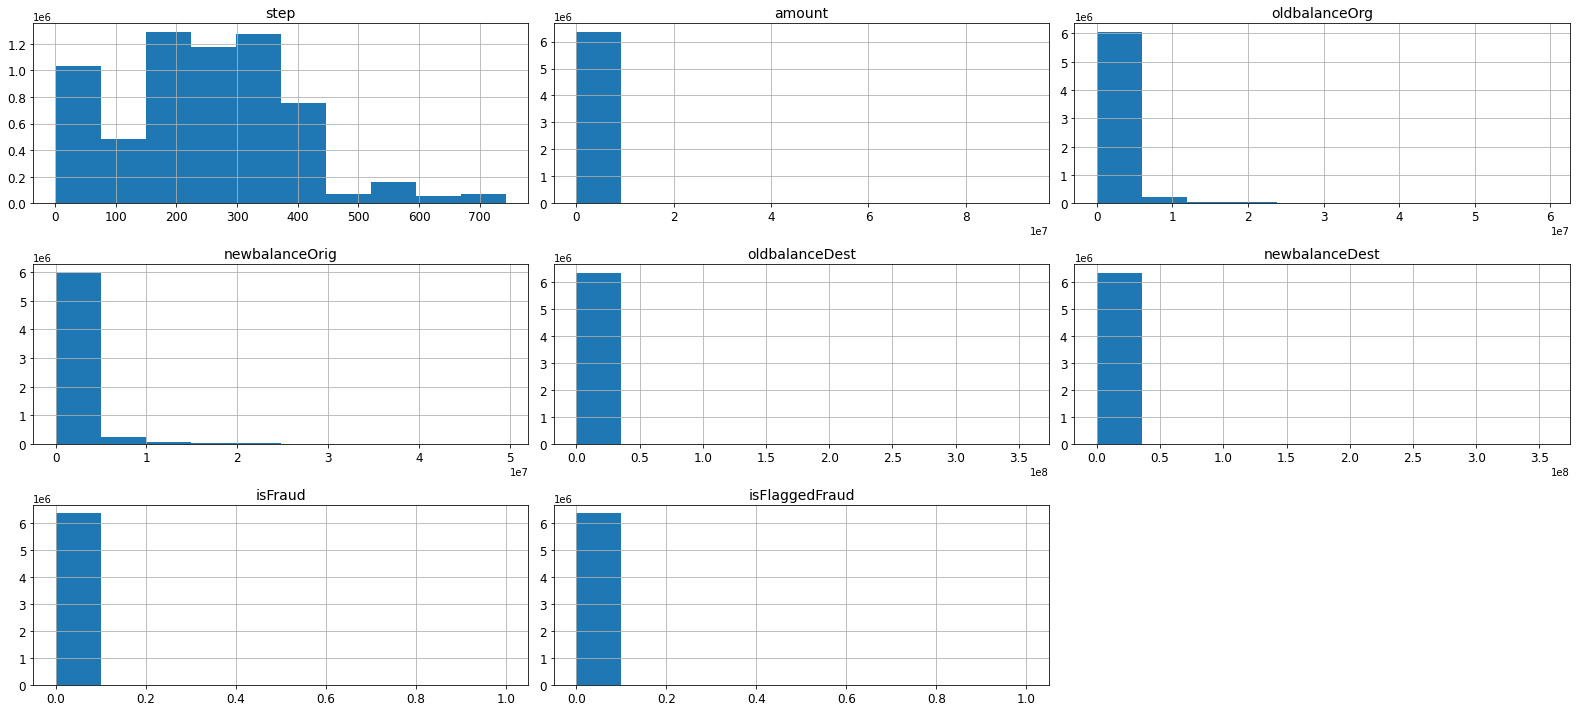

In [11]:
display_dataset_distributions(df)

Se muestra en un gráfico la cantidad de operaciones según el tipo de transacción.

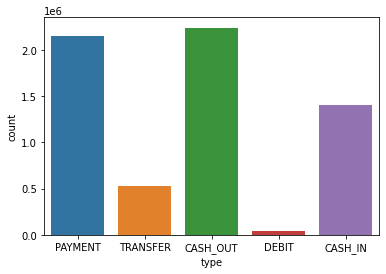

In [12]:
sns.countplot(x = 'type',data = df)

Veamos el balance de clases ('isFraud').

0    6354407
1       8213
Name: isFraud, dtype: int64


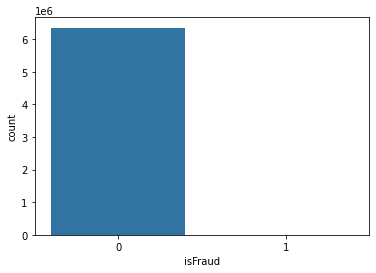

In [13]:
sns.countplot(x = 'isFraud', data = df)
print(df['isFraud'].value_counts())

Se observa que las clases del dataset están muy desbalanceadas.

A continuación se muestra como se distribuyen las operaciones fraudulentas en función del tipo de transacción.

          isFraud
type             
CASH_IN         0
CASH_OUT     4116
DEBIT           0
PAYMENT         0
TRANSFER     4097


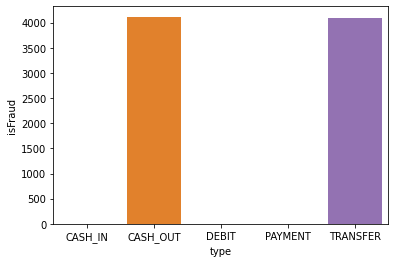

In [14]:
type_df = pd.DataFrame(df.groupby(by = df['type'])['isFraud'].sum())
sns.barplot(data = type_df, x = type_df.index, y = 'isFraud')
print(type_df)

Se observa que solo las transacciones CASHOUT y TRANFER tienen operaciones fraudulentas. Esto motiva a eliminar el resto de las transacciones antes de comenzar con el aprendizaje de los modelos.

In [15]:
df_drop = df.drop(df[(df['type'] == 'CASH_IN') |
                     (df['type'] == 'DEBIT') |
                     (df['type'] == 'PAYMENT')].index)

0    2762196
1       8213
Name: isFraud, dtype: int64


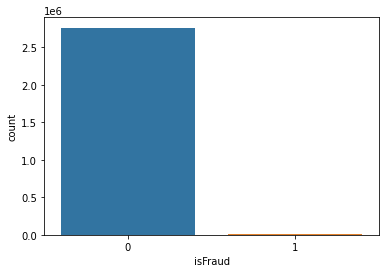

In [16]:
sns.countplot(x = 'isFraud', data = df_drop)
print(df_drop['isFraud'].value_counts())

Algo se redujo el desbalance de clases pero todavía es grande. Se van a adoptar estrategias vistas en clase para balancear.
A continuación se divide el dataset en features 'X' y variable objetivo 'y'. Dentro de las features, no van a entrar en consideración 'nameOrig', 'nameDest' y step.

In [17]:
X, y = df_drop[['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']],df_drop.isFraud
X.dtypes

type               object
amount            float64
oldbalanceOrg     float64
newbalanceOrig    float64
oldbalanceDest    float64
newbalanceDest    float64
dtype: object

Se separan las features en numéricas y categóricas. A las numéricas se las escala y a las categóricas se las codifica.

In [18]:
numeric_features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
categorical_features = ['type']

In [19]:
#numeric_transformer = StandardScaler()
numeric_transformer = MinMaxScaler()

In [20]:
categorical_transformer = OneHotEncoder()

In [21]:
preprocessor = ColumnTransformer(transformers=[
               ('num', numeric_transformer, numeric_features),
               ('cat', categorical_transformer, categorical_features)])

### Split del dataset y balanceo de clases

Ahora se divide el dataset en train y test (0.8 y 0.2 respectivamente) y se estratifican las clases. Luego se van a definir diferentes técnicas para balancear las clases. 

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=432, stratify = y)

print('Entrenamiento:',X_train.shape)
print('Testeo:',X_test.shape)
print('\nClases train:')
print(y_train.value_counts(normalize=True))
print('\nClases test:')
print(y_test.value_counts(normalize=True))

Entrenamiento: (2216327, 6)
Testeo: (554082, 6)

Clases train:
0    0.997036
1    0.002964
Name: isFraud, dtype: float64

Clases test:
0    0.997035
1    0.002965
Name: isFraud, dtype: float64


Como primer técnica de balanceo se utiliza Undersampling.

In [23]:
undersampler=RandomUnderSampler(sampling_strategy = 'majority');

X_train_us,y_train_us=undersampler.fit_resample(X_train,y_train);

print('Composición del training set:')
print(y_train_us.value_counts())
print('\nComposición del test set:')
print(y_test.value_counts())

Composición del training set:
0    6570
1    6570
Name: isFraud, dtype: int64

Composición del test set:
0    552439
1      1643
Name: isFraud, dtype: int64


Como segunda técnica de balanceo se utiliza Oversampling.

In [24]:
oversampler=RandomOverSampler(sampling_strategy='minority');

X_train_os,y_train_os=oversampler.fit_resample(X_train,y_train);

print('Composición del training set:')
print(y_train_os.value_counts())

print('\nComposición del test set:')
print(y_test.value_counts())

Composición del training set:
0    2209757
1    2209757
Name: isFraud, dtype: int64

Composición del test set:
0    552439
1      1643
Name: isFraud, dtype: int64


### Entrenamiento y evaluación

A continuación se entrenan diferentes modelos (estudiados en clase):

* Random Forest
* Tree decision
* Regresión logística
* SVM

#### Random Forest

In [25]:
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier(n_estimators= 100, random_state=432))])

In [26]:
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)
y_pred2 = model.predict(X_test)

In [27]:
print('Métricas alcanzadas con el dataset estratificado')
print(classification_report(y_test,y_pred2))

Métricas alcanzadas con el dataset estratificado
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552439
           1       0.98      0.75      0.85      1643

    accuracy                           1.00    554082
   macro avg       0.99      0.88      0.92    554082
weighted avg       1.00      1.00      1.00    554082



In [28]:
model.fit(X_train_us, y_train_us)
y_pred_us = model.predict_proba(X_test)
y_pred2_us = model.predict(X_test)

In [29]:
print('Métricas alcanzadas con el dataset undersampleado')
print(classification_report(y_test,y_pred2_us))

Métricas alcanzadas con el dataset undersampleado
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    552439
           1       0.15      0.99      0.26      1643

    accuracy                           0.98    554082
   macro avg       0.57      0.99      0.63    554082
weighted avg       1.00      0.98      0.99    554082



In [30]:
model.fit(X_train_os, y_train_os)
y_pred_os = model.predict_proba(X_test)
y_pred2_os = model.predict(X_test)

In [31]:
print('Métricas alcanzadas con el dataset oversampleado')
print(classification_report(y_test,y_pred2_os))

Métricas alcanzadas con el dataset oversampleado
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552439
           1       0.93      0.82      0.87      1643

    accuracy                           1.00    554082
   macro avg       0.96      0.91      0.93    554082
weighted avg       1.00      1.00      1.00    554082



In [32]:
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier(n_estimators= 100, class_weight = 'balanced', random_state=432))])

model.fit(X_train, y_train)
y_pred_c_wght = model.predict_proba(X_test)
y_pred2_c_wght = model.predict(X_test)

print('Métricas alcanzadas con el dataset con class weight')
print(classification_report(y_test,y_pred2_c_wght))

Métricas alcanzadas con el dataset con class weight
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552439
           1       0.96      0.78      0.86      1643

    accuracy                           1.00    554082
   macro avg       0.98      0.89      0.93    554082
weighted avg       1.00      1.00      1.00    554082



##### Curva ROC/AUC

La curva ROC y el área bajo la misma AUC interpreta que tan bueno es el modelo para distinguir entre dos cosas, en nuestro caso, si una transacción es fraudulenta o no.

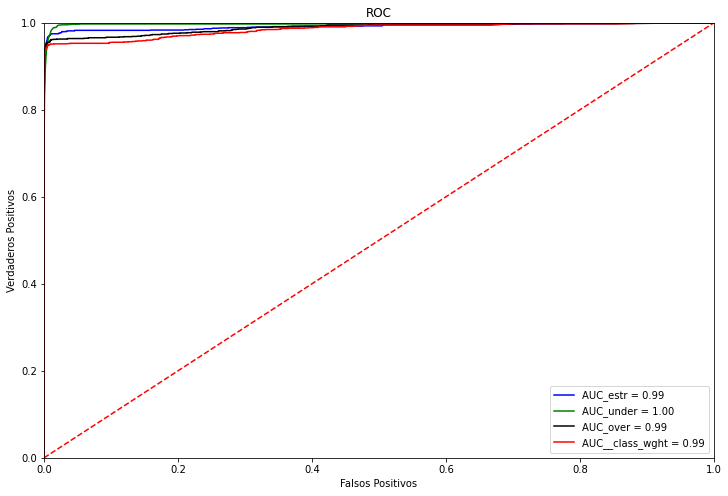

In [33]:
fig,axes = plt.subplots(1,1,figsize=(12,8))

axes.set_title('ROC')
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred[:,1])
roc_auc_estratif = metrics.auc(fpr, tpr)
axes.plot(fpr, tpr, 'b', label = 'AUC_estr = %0.2f' % roc_auc_estratif)
axes.legend(loc = 'lower right')
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_us[:,1])
roc_auc_undersamp = metrics.auc(fpr, tpr)
axes.plot(fpr, tpr, 'g', label = 'AUC_under = %0.2f' % roc_auc_undersamp)
axes.legend(loc = 'lower right')
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_os[:,1])
roc_auc_oversamp = metrics.auc(fpr, tpr)
axes.plot(fpr, tpr, 'k', label = 'AUC_over = %0.2f' % roc_auc_oversamp)
axes.legend(loc = 'lower right')
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_c_wght[:,1])
roc_auc_class_wght = metrics.auc(fpr, tpr)
axes.plot(fpr, tpr, 'r', label = 'AUC__class_wght = %0.2f' % roc_auc_class_wght)
axes.legend(loc = 'lower right')

axes.plot([0, 1], [0, 1],'r--')
axes.set_xlim([0, 1])
axes.set_ylim([0, 1])
axes.set_ylabel('Verdaderos Positivos')
axes.set_xlabel('Falsos Positivos');

##### Matriz de confusión

La matriz de confusión es una herramienta que nos muestra el desempeño del algoritmo de clasificación, describiendo cómo se distribuyen los valores reales y nuestras predicciones.

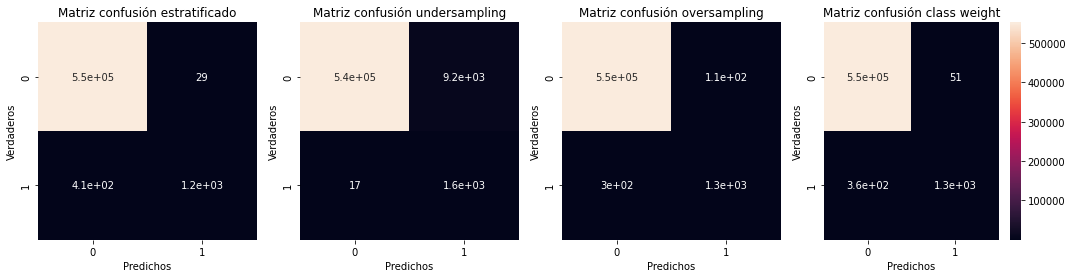

In [34]:
fig, ax =plt.subplots(1, 4, figsize=(18,4))

confusion_matrix(y_test, y_pred2)
sns.heatmap(confusion_matrix(y_test, y_pred2), annot=True, ax = ax[0], cbar = False)
ax[0].set_title('Matriz confusión estratificado')
ax[0].set_ylabel('Verdaderos')
ax[0].set_xlabel('Predichos')

confusion_matrix(y_test, y_pred2_us)
sns.heatmap(confusion_matrix(y_test, y_pred2_us), annot=True, ax = ax[1], cbar = False)
ax[1].set_title('Matriz confusión undersampling')
ax[1].set_ylabel('Verdaderos')
ax[1].set_xlabel('Predichos')

confusion_matrix(y_test, y_pred2_os)
sns.heatmap(confusion_matrix(y_test, y_pred2_os), annot=True, ax = ax[2], cbar = False)
ax[2].set_title('Matriz confusión oversampling')
ax[2].set_ylabel('Verdaderos')
ax[2].set_xlabel('Predichos')

confusion_matrix(y_test, y_pred2_c_wght)
sns.heatmap(confusion_matrix(y_test, y_pred2_c_wght), annot=True, ax = ax[3])
ax[3].set_title('Matriz confusión class weight')
ax[3].set_ylabel('Verdaderos')
ax[3].set_xlabel('Predichos')

plt.show()

**El desempeño de Random Forest es muy bueno. Se observa que no hay una técnica de balance de clases que mejore el desempeño del modelo respecto a otra.**

#### Tree decision classifier

In [35]:
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier',tree.DecisionTreeClassifier(max_depth = 10, criterion = 'entropy', random_state=432))])

In [36]:
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)
y_pred2 = model.predict(X_test)

In [37]:
print('Métricas alcanzadas con el dataset estratificado')
print(classification_report(y_test,y_pred2))

Métricas alcanzadas con el dataset estratificado
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552439
           1       0.97      0.73      0.83      1643

    accuracy                           1.00    554082
   macro avg       0.98      0.87      0.92    554082
weighted avg       1.00      1.00      1.00    554082



In [38]:
model.fit(X_train_us, y_train_us)
y_pred_us = model.predict_proba(X_test)
y_pred2_us = model.predict(X_test)

In [39]:
print('Métricas alcanzadas con el dataset undersampleado')
print(classification_report(y_test,y_pred2_us))

Métricas alcanzadas con el dataset undersampleado
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    552439
           1       0.14      0.99      0.25      1643

    accuracy                           0.98    554082
   macro avg       0.57      0.99      0.62    554082
weighted avg       1.00      0.98      0.99    554082



In [40]:
model.fit(X_train_os, y_train_os)
y_pred_os = model.predict_proba(X_test)
y_pred2_os = model.predict(X_test)

In [41]:
print('Métricas alcanzadas con el dataset oversampleado')
print(classification_report(y_test,y_pred2_os))

Métricas alcanzadas con el dataset oversampleado
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    552439
           1       0.26      0.93      0.41      1643

    accuracy                           0.99    554082
   macro avg       0.63      0.96      0.70    554082
weighted avg       1.00      0.99      0.99    554082



In [42]:
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier',tree.DecisionTreeClassifier(max_depth = 2, class_weight = 'balanced', criterion = 'entropy', random_state=432))])

model.fit(X_train, y_train)
y_pred_c_wght = model.predict_proba(X_test)
y_pred2_c_wght = model.predict(X_test)

print('Métricas alcanzadas con el dataset con class weight')
print(classification_report(y_test,y_pred2_c_wght))

Métricas alcanzadas con el dataset con class weight
              precision    recall  f1-score   support

           0       1.00      0.92      0.96    552439
           1       0.03      0.82      0.06      1643

    accuracy                           0.92    554082
   macro avg       0.52      0.87      0.51    554082
weighted avg       1.00      0.92      0.96    554082



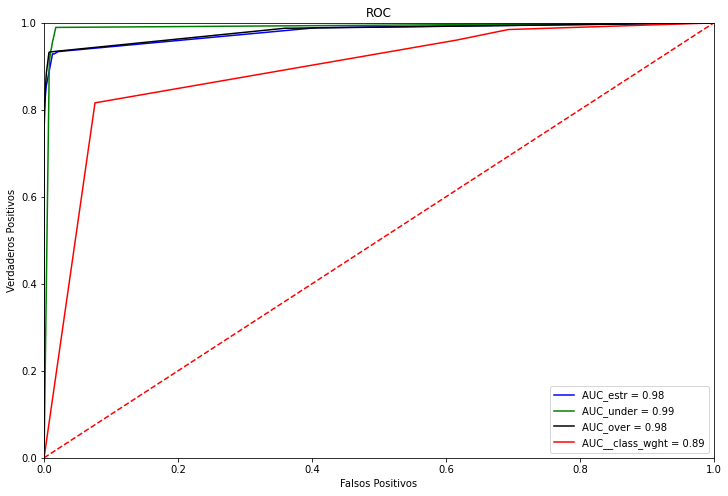

In [43]:
fig,axes = plt.subplots(1,1,figsize=(12,8))

axes.set_title('ROC')
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred[:,1])
roc_auc_estratif = metrics.auc(fpr, tpr)
axes.plot(fpr, tpr, 'b', label = 'AUC_estr = %0.2f' % roc_auc_estratif)
axes.legend(loc = 'lower right')
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_us[:,1])
roc_auc_undersamp = metrics.auc(fpr, tpr)
axes.plot(fpr, tpr, 'g', label = 'AUC_under = %0.2f' % roc_auc_undersamp)
axes.legend(loc = 'lower right')
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_os[:,1])
roc_auc_oversamp = metrics.auc(fpr, tpr)
axes.plot(fpr, tpr, 'k', label = 'AUC_over = %0.2f' % roc_auc_oversamp)
axes.legend(loc = 'lower right')
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_c_wght[:,1])
roc_auc_class_wght = metrics.auc(fpr, tpr)
axes.plot(fpr, tpr, 'r', label = 'AUC__class_wght = %0.2f' % roc_auc_class_wght)
axes.legend(loc = 'lower right')

axes.plot([0, 1], [0, 1],'r--')
axes.set_xlim([0, 1])
axes.set_ylim([0, 1])
axes.set_ylabel('Verdaderos Positivos')
axes.set_xlabel('Falsos Positivos');

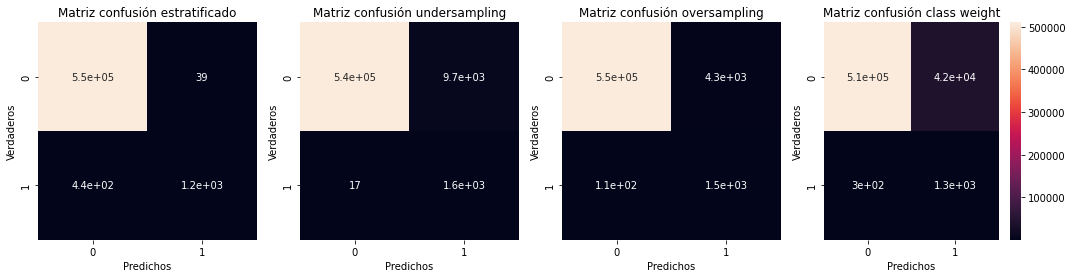

In [44]:
fig, ax =plt.subplots(1, 4, figsize=(18,4))

confusion_matrix(y_test, y_pred2)
sns.heatmap(confusion_matrix(y_test, y_pred2), annot=True, ax = ax[0], cbar = False)
ax[0].set_title('Matriz confusión estratificado')
ax[0].set_ylabel('Verdaderos')
ax[0].set_xlabel('Predichos')

confusion_matrix(y_test, y_pred2_us)
sns.heatmap(confusion_matrix(y_test, y_pred2_us), annot=True, ax = ax[1], cbar = False)
ax[1].set_title('Matriz confusión undersampling')
ax[1].set_ylabel('Verdaderos')
ax[1].set_xlabel('Predichos')

confusion_matrix(y_test, y_pred2_os)
sns.heatmap(confusion_matrix(y_test, y_pred2_os), annot=True, ax = ax[2], cbar = False)
ax[2].set_title('Matriz confusión oversampling')
ax[2].set_ylabel('Verdaderos')
ax[2].set_xlabel('Predichos')

confusion_matrix(y_test, y_pred2_c_wght)
sns.heatmap(confusion_matrix(y_test, y_pred2_c_wght), annot=True, ax = ax[3])
ax[3].set_title('Matriz confusión class weight')
ax[3].set_ylabel('Verdaderos')
ax[3].set_xlabel('Predichos')

plt.show()

**La técnica de balance de clases tiene influencia en el desempeño del modelo cuando se usa Tree Decision Classifier. Se observa que no es muy bueno cuando se emplea class weight. Sin embargo, undesampling mejora sustancialmente la performance.**

#### Regresión logística

In [45]:
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LogisticRegression(solver = 'lbfgs', random_state = 432))])

In [46]:
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)
y_pred2 = model.predict(X_test)

In [47]:
print('Métricas alcanzadas con el dataset estratificado')
print(classification_report(y_test,y_pred2))

Métricas alcanzadas con el dataset estratificado
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552439
           1       0.97      0.11      0.19      1643

    accuracy                           1.00    554082
   macro avg       0.98      0.55      0.60    554082
weighted avg       1.00      1.00      1.00    554082



In [48]:
model.fit(X_train_us, y_train_us)
y_pred_us = model.predict_proba(X_test)
y_pred2_us = model.predict(X_test)

In [49]:
print('Métricas alcanzadas con el dataset undersampleado')
print(classification_report(y_test,y_pred2_us))

Métricas alcanzadas con el dataset undersampleado
              precision    recall  f1-score   support

           0       1.00      0.81      0.90    552439
           1       0.01      0.66      0.02      1643

    accuracy                           0.81    554082
   macro avg       0.50      0.74      0.46    554082
weighted avg       1.00      0.81      0.89    554082



In [50]:
model.fit(X_train_os, y_train_os)
y_pred_os = model.predict_proba(X_test)
y_pred2_os = model.predict(X_test)

In [51]:
print('Métricas alcanzadas con el dataset oversampleado')
print(classification_report(y_test,y_pred2_os))

Métricas alcanzadas con el dataset oversampleado
              precision    recall  f1-score   support

           0       1.00      0.93      0.97    552439
           1       0.04      0.82      0.07      1643

    accuracy                           0.93    554082
   macro avg       0.52      0.88      0.52    554082
weighted avg       1.00      0.93      0.96    554082



In [52]:
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LogisticRegression(solver = 'lbfgs', class_weight = 'balanced', random_state = 432))])

model.fit(X_train, y_train)
y_pred_c_wght = model.predict_proba(X_test)
y_pred2_c_wght = model.predict(X_test)

print('Métricas alcanzadas con el dataset con class weight')
print(classification_report(y_test,y_pred2_c_wght))

Métricas alcanzadas con el dataset con class weight
              precision    recall  f1-score   support

           0       1.00      0.93      0.96    552439
           1       0.03      0.81      0.06      1643

    accuracy                           0.93    554082
   macro avg       0.52      0.87      0.51    554082
weighted avg       1.00      0.93      0.96    554082



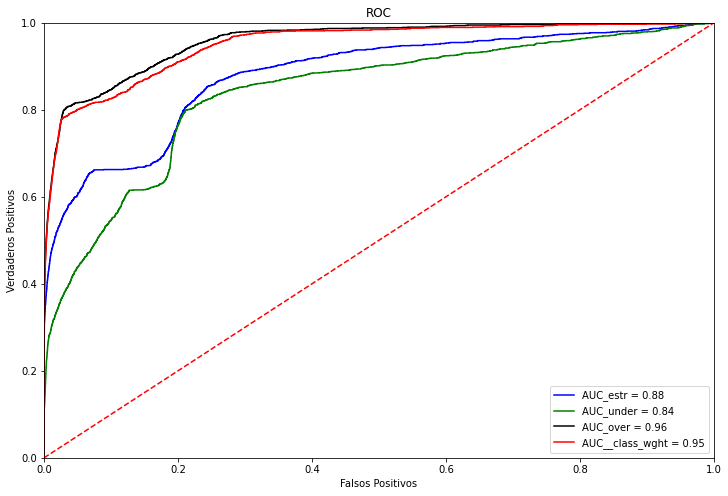

In [53]:
fig,axes = plt.subplots(1,1,figsize=(12,8))

axes.set_title('ROC')
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred[:,1])
roc_auc_estratif = metrics.auc(fpr, tpr)
axes.plot(fpr, tpr, 'b', label = 'AUC_estr = %0.2f' % roc_auc_estratif)
axes.legend(loc = 'lower right')
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_us[:,1])
roc_auc_undersamp = metrics.auc(fpr, tpr)
axes.plot(fpr, tpr, 'g', label = 'AUC_under = %0.2f' % roc_auc_undersamp)
axes.legend(loc = 'lower right')
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_os[:,1])
roc_auc_oversamp = metrics.auc(fpr, tpr)
axes.plot(fpr, tpr, 'k', label = 'AUC_over = %0.2f' % roc_auc_oversamp)
axes.legend(loc = 'lower right')
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_c_wght[:,1])
roc_auc_class_wght = metrics.auc(fpr, tpr)
axes.plot(fpr, tpr, 'r', label = 'AUC__class_wght = %0.2f' % roc_auc_class_wght)
axes.legend(loc = 'lower right')

axes.plot([0, 1], [0, 1],'r--')
axes.set_xlim([0, 1])
axes.set_ylim([0, 1])
axes.set_ylabel('Verdaderos Positivos')
axes.set_xlabel('Falsos Positivos');

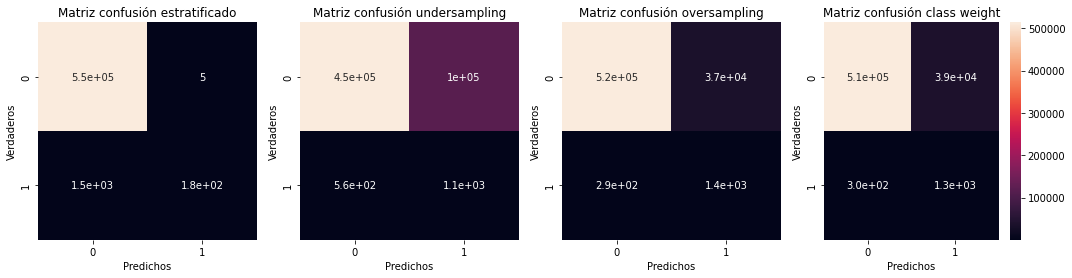

In [54]:
fig, ax =plt.subplots(1, 4, figsize=(18,4))

confusion_matrix(y_test, y_pred2)
sns.heatmap(confusion_matrix(y_test, y_pred2), annot=True, ax = ax[0], cbar = False)
ax[0].set_title('Matriz confusión estratificado')
ax[0].set_ylabel('Verdaderos')
ax[0].set_xlabel('Predichos')

confusion_matrix(y_test, y_pred2_us)
sns.heatmap(confusion_matrix(y_test, y_pred2_us), annot=True, ax = ax[1], cbar = False)
ax[1].set_title('Matriz confusión undersampling')
ax[1].set_ylabel('Verdaderos')
ax[1].set_xlabel('Predichos')

confusion_matrix(y_test, y_pred2_os)
sns.heatmap(confusion_matrix(y_test, y_pred2_os), annot=True, ax = ax[2], cbar = False)
ax[2].set_title('Matriz confusión oversampling')
ax[2].set_ylabel('Verdaderos')
ax[2].set_xlabel('Predichos')

confusion_matrix(y_test, y_pred2_c_wght)
sns.heatmap(confusion_matrix(y_test, y_pred2_c_wght), annot=True, ax = ax[3])
ax[3].set_title('Matriz confusión class weight')
ax[3].set_ylabel('Verdaderos')
ax[3].set_xlabel('Predichos')

plt.show()

**Hasta el momento la Regresión Logística es el modelo que tiene el peor desempeño, aunque es bueno. A diferencia del modelo Tree Decision Classifier, la técnica de undesampling empeora los resultados. El mejor desempeño se logra con oversampling.**

#### SVM (Support vector machine)

In [55]:
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LinearSVC(random_state = 432))])

In [56]:
model.fit(X_train, y_train)
#y_pred = model.predict_proba(X_test)
y_pred2 = model.predict(X_test)

In [57]:
print('Métricas alcanzadas con el dataset estratificado')
print(classification_report(y_test,y_pred2))

Métricas alcanzadas con el dataset estratificado
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552439
           1       0.98      0.23      0.37      1643

    accuracy                           1.00    554082
   macro avg       0.99      0.62      0.69    554082
weighted avg       1.00      1.00      1.00    554082



In [58]:
model.fit(X_train_us, y_train_us)
y_pred2_us = model.predict(X_test)

In [59]:
print('Métricas alcanzadas con el dataset undersampleado')
print(classification_report(y_test,y_pred2_us))

Métricas alcanzadas con el dataset undersampleado
              precision    recall  f1-score   support

           0       1.00      0.84      0.91    552439
           1       0.01      0.71      0.03      1643

    accuracy                           0.84    554082
   macro avg       0.51      0.78      0.47    554082
weighted avg       1.00      0.84      0.91    554082



In [60]:
model.fit(X_train_os, y_train_os)
y_pred2_os = model.predict(X_test)

In [61]:
print('Métricas alcanzadas con el dataset oversampleado')
print(classification_report(y_test,y_pred2_os))

Métricas alcanzadas con el dataset oversampleado
              precision    recall  f1-score   support

           0       1.00      0.93      0.97    552439
           1       0.04      0.85      0.07      1643

    accuracy                           0.93    554082
   macro avg       0.52      0.89      0.52    554082
weighted avg       1.00      0.93      0.96    554082



In [62]:
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LinearSVC(class_weight = 'balanced', random_state = 432))])

model.fit(X_train, y_train)
y_pred2_c_wght = model.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [63]:
print('Métricas alcanzadas con el dataset con class weight')
print(classification_report(y_test,y_pred2_c_wght))

Métricas alcanzadas con el dataset con class weight
              precision    recall  f1-score   support

           0       1.00      0.94      0.97    552439
           1       0.04      0.84      0.08      1643

    accuracy                           0.94    554082
   macro avg       0.52      0.89      0.52    554082
weighted avg       1.00      0.94      0.97    554082



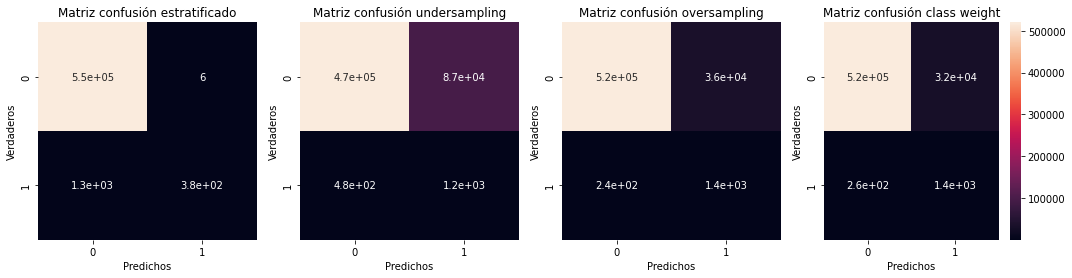

In [64]:
fig, ax =plt.subplots(1, 4, figsize=(18,4))

confusion_matrix(y_test, y_pred2)
sns.heatmap(confusion_matrix(y_test, y_pred2), annot=True, ax = ax[0], cbar = False)
ax[0].set_title('Matriz confusión estratificado')
ax[0].set_ylabel('Verdaderos')
ax[0].set_xlabel('Predichos')

confusion_matrix(y_test, y_pred2_us)
sns.heatmap(confusion_matrix(y_test, y_pred2_us), annot=True, ax = ax[1], cbar = False)
ax[1].set_title('Matriz confusión undersampling')
ax[1].set_ylabel('Verdaderos')
ax[1].set_xlabel('Predichos')

confusion_matrix(y_test, y_pred2_os)
sns.heatmap(confusion_matrix(y_test, y_pred2_os), annot=True, ax = ax[2], cbar = False)
ax[2].set_title('Matriz confusión oversampling')
ax[2].set_ylabel('Verdaderos')
ax[2].set_xlabel('Predichos')

confusion_matrix(y_test, y_pred2_c_wght)
sns.heatmap(confusion_matrix(y_test, y_pred2_c_wght), annot=True, ax = ax[3])
ax[3].set_title('Matriz confusión class weight')
ax[3].set_ylabel('Verdaderos')
ax[3].set_xlabel('Predichos')

plt.show()

**SVM no presenta una gran desempeño.**

### Resumen

Se realizó una análisis previo de los datos contenidos en el dataset.

Algunas columnas como *step*, *nameOrig* y *nameDest* no fueron tenidas en cuenta debido a que no aportan información significativa.

No fue necesario implementar ninguna técnica de imputación de datos faltantes Nan.

Se observó que *isFraud* estaba muy desbalanceada, sin embargo, se hizo un filtrado previo de los tipos de operaciones que eran fraudulentas, encontrando solo 2 tipos *cashout* y *transfer*. Este filtrado redujo el desbalance pero no muy significativamente.

A la feature categórica *type* se la codificó con OHE y a las features numéricas se las normalizó.

Previo al comienzo del entrenamiento de los diferentes modelos aprendidos en clase, se balanceó el dataset con diferentes técnicas, tales como, *estratificación*, *undersampling*, etc.

Por último, se entrenaron 4 modelos distintos de clasificación. Se observó que ningún desempeño fue tan malo si se tiene en cuenta el desbalance propio del dataset. Se puede concluir que ***Random Forest*** arrojó las mejores métricas.